In [1]:
# Pulling cleaned data

import joblib

X_scaled = joblib.load("X_scaled.pkl")
y = joblib.load("y.pkl")
feature_names = joblib.load("feature_names.pkl")

<!-- Train/Test Split

We split the dataset into a training set (X_train / y_train) and a testing set (X_test / y_test).
- The test set must be held out before training to avoid data leakage.
- An 80/20 split is a common practice: 20% is sufficient for evaluation, while 80% maximizes training data.
- Setting `random_state` ensures the split is reproducible so all team members get identical results.
- Using `stratify=y` preserves the original class distribution, preventing cases where the training set becomes mostly BENIGN and the test set mostly ATTACK.  --> 

In [2]:
# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size = 0.2, # -- 80% training, 20% testing
    random_state = 42,
    stratify = y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (48800, 78)
Test set shape: (12201, 78)


<!-- Train–Validation Split

From the previous 80% training split, we take 20% to create a separate validation set.
This validation set is used for tuning hyperparameters and checking model generalization.
Note: 20% of the original 80% equals 16% of the full dataset. -->

In [3]:
# train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,      # 20% from 80% training →  16% of total
    random_state = 42,
    stratify = y_train
)

print("Train shape after splitting:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape after splitting: (39040, 78)
Validation shape: (9760, 78)
Test shape: (12201, 78)


<!-- Random Forest Model

We use a Random Forest model as our primary classifier.  
RF is chosen because it is:
- Robust to noise and overfitting  
- Effective on high-dimensional data  
- Easy to tune  
- Provides feature importance for interpretability  -->

In [4]:
# RF Classifier 

from sklearn.ensemble import RandomForestClassifier

# -- building model

rf_clf = RandomForestClassifier(
    n_estimators = 200, # n of trees
    max_depth = None,
    random_state = 42,
    n_jobs = -1 # use all cpu cores
)

# -- training model

rf_clf.fit(X_train, y_train)

print("RF training completed.")

RF training completed.


<!-- Model Validation

These values indicate that the model almost perfectly distinguishes between ’BENIGN‘ and ’ATTACK‘ traffic on the validation set.
Key observations:
- High precision means the model rarely produces false alarms.
- Extremely high recall shows the model is able to detect nearly all actual attacks.
- High F1 score confirms that the model maintains an excellent balance between precision and recall.
These results suggest that the model generalizes well to unseen data and does not exhibit signs of under-fitting. -->

In [5]:
# Model vali
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_val_pred = rf_clf.predict(X_val)

print("\nValidation Metrics:")
print("Vali Accuracy :", accuracy_score(y_val, y_val_pred))
print("Vali Precision:", precision_score(y_val, y_val_pred))
print("Vali Recall   :", recall_score(y_val, y_val_pred))
print("Vali F1 Score :", f1_score(y_val, y_val_pred))


Validation Metrics:
Vali Accuracy : 0.9993852459016394
Vali Precision: 0.9994422132976349
Vali Recall   : 0.9998883928571428
Vali F1 Score : 0.999665253291676


<!-- Model Test Evaluation

The test results represent the model’s final performance on completely unseen data.
Key observations:
- Accuracy remains extremely high, confirming strong generalization beyond the training process.
- Precision and recall for both BENIGN and ATTACK classes are nearly perfect, showing consistent behavior across different data distributions.
- The confusion matrix indicates only a very small number of misclassifications:
- Very few false positives (BENIGN → ATTACK), meaning minimal unnecessary alerts.
- Extremely low false negatives (ATTACK → BENIGN), which is critical for security applications.
Overall, the final test evaluation validates the robustness of the Random Forest model and confirms that it maintains high reliability in intrusion detection scenarios. -->

In [6]:
# Model eval

from sklearn.metrics import classification_report, confusion_matrix

# -- preds
y_pred = rf_clf.predict(X_test)

# -- accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4f}".format(acc))

# -- classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["BENIGN", "ATTACK"]))

# -- confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9995

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       999
      ATTACK       1.00      1.00      1.00     11202

    accuracy                           1.00     12201
   macro avg       1.00      1.00      1.00     12201
weighted avg       1.00      1.00      1.00     12201

Confusion Matrix:
[[  995     4]
 [    2 11200]]


<!-- Model Evaluation – ROC, PR, and AUC

- ROC and PR curves are used to evaluate the model across all decision thresholds, instead of using a single cut-off like 0.5.
- ROC Curve: Checks the tradeoff between true positive rate and false positive rate.
AUC ≈ 0.999 shows the model almost perfectly separates BENIGN vs ATTACK.
- Precision–Recall Curve: More informative for imbalanced datasets.
The curve staying near (precision≈1, recall≈1) indicates extremely confident and accurate detection.
- Overall: The model's probability outputs show very strong separation,
suggesting that the features make attacks easy to distinguish in this dataset. -->

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


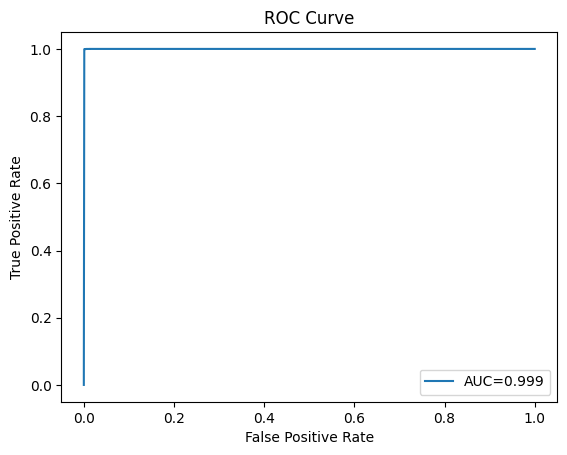

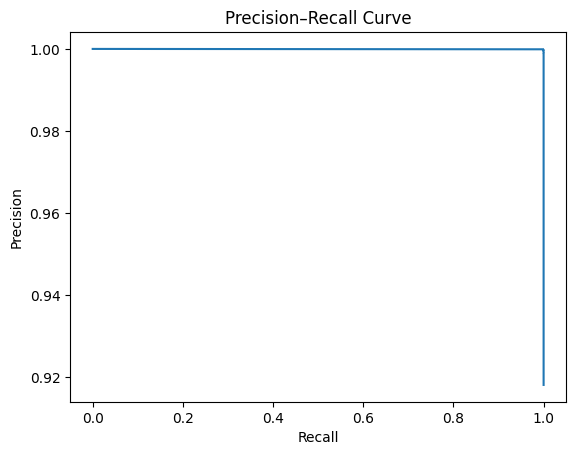

AUC Score: 0.9994859169113766


In [7]:
# Model eval 
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

y_scores = rf_clf.predict_proba(X_test)[:, 1]
print(y_scores[:20])

# ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# AUC
print("AUC Score:", roc_auc)